In [1]:
import numpy as np
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
import os
from sklearn.metrics import mean_squared_error

#### define directories and load data 

In [2]:
data_dir = '/storage/yw18581/data/'
data_folder = os.path.join(data_dir, 'train_validation_test')

In [3]:
X_train = np.load(os.path.join(data_folder, 'Xy_train_dist.npz'))["y"]
y_train = np.load(os.path.join(data_folder, 'Xy_train_dist.npz'))["dist"]


In [4]:
X_val = np.load(os.path.join(data_folder,'Xy_val_dist.npz'))["y"]
y_val = np.load(os.path.join(data_folder, 'Xy_val_dist.npz'))["dist"]

In [5]:
X_test = np.load(os.path.join(data_folder, 'Xy_test_dist.npz'))["y"]
y_test = np.load(os.path.join(data_folder, 'Xy_test_dist.npz'))["dist"]

X_test_5classes = np.load(os.path.join(data_folder, "Xy_test_strat_dist_5classes.npz"))["y"]
y_test_5classes = np.load(os.path.join(data_folder, "Xy_test_strat_dist_5classes.npz"))["dist"]

In [6]:
X_15mm = np.load(os.path.join(data_folder, "Xy_15mm.npz"))["y"]
y_15mm = np.load(os.path.join(data_folder, "Xy_15mm.npz"))["dist"]

#### reshape data for Random Forest

In [7]:
def cut_X(arr, reshape = None):
    x_cut = arr[:,960:1300,600:]
    if reshape:
        if len(x_cut.shape)>3:
            x_cut = x_cut[...,0]
            x_cut_out = x_cut.reshape(x_cut.shape[0],x_cut.shape[1]*x_cut.shape[2])
    else:
        x_cut_out = x_cut
    return x_cut_out

def reshape_RF(arr):
    arr_RF = arr.reshape((arr.shape[0], arr.shape[1]*arr.shape[2]))
    return arr_RF

In [8]:
X_train_cut = cut_X(X_train)
X_val_cut = cut_X(X_val)
X_test_cut = cut_X(X_test)
X_15mm_cut = cut_X(X_15mm)
X_train_RF = reshape_RF(X_train_cut)
X_val_RF = reshape_RF(X_val_cut)
X_test_RF = reshape_RF(X_test_cut)
X_15mm_RF  = reshape_RF(X_15mm_cut)

rf_grid = joblib.load("rf_best_estimator.pkl")

In [14]:
preds_test= rf_grid.predict(X_test_RF)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


In [15]:
mean_squared_error(y_test, preds_test)

0.025309259259259264

In [16]:
preds_15mm = rf_grid.predict(X_15mm_RF)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


In [17]:
mean_squared_error(y_15mm, preds_15mm)

6.777255444444445

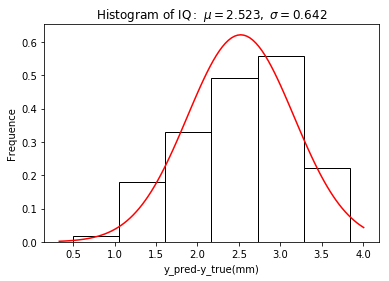

In [21]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

data = preds_15mm-y_15mm
mean,std=norm.fit(data)

plt.hist(data, bins=6, normed=True, facecolor='white',edgecolor ="k",  alpha=1)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y, c='r')
plt.xlabel('y_pred-y_true(mm)')
plt.ylabel('Frequence')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=%.3f,\ \sigma=%.3f$' %(mean, std))
plt.show()

In [15]:
# %load Leaf_regression_RF_gridsearchCV.py
#!/usr/bin/env python

import numpy as np
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
import os
import os.path as p
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV

In [16]:

X_train_RF = np.vstack((X_train_RF, X_val_RF))
print(X_train_RF.shape)

y_train = np.hstack((y_train,y_val))
y_train.shape

print(X_train_RF.shape, y_train.shape)

from sklearn.model_selection import StratifiedKFold
X = X_train_RF
y = y_train

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)


(960, 272000)
(960, 272000) (960,)


5

In [22]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [23]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = skf, verbose=10, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_RF, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 12.7min


KeyboardInterrupt: 

Exception in thread QueueManagerThread:
Traceback (most recent call last):
  File "/users/yw18581/.conda/envs/fluffy-bunnies/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/users/yw18581/.conda/envs/fluffy-bunnies/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/users/yw18581/.conda/envs/fluffy-bunnies/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py", line 747, in _queue_management_worker
    recursive_terminate(p)
  File "/users/yw18581/.conda/envs/fluffy-bunnies/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "/users/yw18581/.conda/envs/fluffy-bunnies/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/backend/utils.py", line 53, in _recursive_terminate_without_psutil
    _recursive_terminate(process.pid)
  File "/user

In [ ]:
rf_random.best_estimator_

# rf_best = rf_random.best_estimator_
#joblib.dump(model.best_estimator_, 'rf_best_estimator.pkl', compress=1)




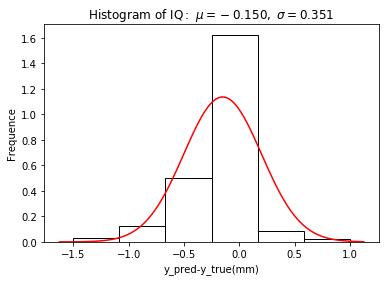

In [257]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

data = preds_15mm-y_15mm
mean,std=norm.fit(data)

plt.hist(data, bins=6, normed=True, facecolor='white',edgecolor ="k",  alpha=1)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y, c='r')
plt.xlabel('y_pred-y_true(mm)')
plt.ylabel('Frequence')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=%.3f,\ \sigma=%.3f$' %(mean, std))
plt.show()